In [1]:
import numpy as np
import pandas as pd

import time
from functools import reduce
from typing import TypeVar, Callable

T = TypeVar('T')
from typing import List

import matplotlib.pyplot as plt
import pandas as pd
from random import shuffle
import statistics


def data_set_from_csv(train_file: str, test_file: str = None):
    def read_file(file):
        ds = pd.read_csv(file)
        return ds.values[:, :-1], ds.values[:, -1]

    train_X, train_y = read_file(train_file)
    test_X, test_y = None, None

    if test_file is not None:
        test_X, test_y = read_file(test_file)
    return DataSet(train_X, train_y, test_X, test_y)


class DataSet:
    def __init__(self, X: np.ndarray, y: np.ndarray, test_X=None, test_y=None):
        self.X = X
        self.y = y

        self._test_X = test_X
        self._test_y = test_y

    def get_X(self):
        return self.X

    def get_y(self):
        return self.y

    def get_test_X(self):
        return self._test_X

    def get_test_y(self):
        return self._test_y

    def count(self):
        return self.y.shape[0]

    def get_for_cross_validation(self, train_indices, test_indices):
        train_X, test_X = self.X[train_indices], self.X[test_indices]
        train_y, test_y = self.y[train_indices], self.y[test_indices]

        return DataSet(X=train_X, y=train_y, test_X=test_X, test_y=test_y)

    def __repr__(self):
        count, features = self.X.shape
        test_count = self.get_test_X().shape[0] if self.get_test_X() is not None else 0
        return f"DataSet[features={features},count={count},test_count={test_count}]"


class DSWithSplit:

    def __init__(self, X, y, split):
        assert X is not None
        assert y is not None
        assert split is not None

        self.X = X
        self.y = y
        self.splits = split

    def __repr__(self):
        return f'DataSet[n_features={self.X.shape[1]},size={self.X.shape[0]},split_size={len(self.splits)}]'

    def split_first(self):
        assert len(self.splits) > 0

        splt = self.splits[0]
        return self.X[splt[0]], self.y[splt[0]], self.X[splt[1]], self.y[splt[1]]


class DSBuilder:
    _TEST = 'test'
    _TRAIN = 'train'

    def __init__(self):
        self._parts = []

    @staticmethod
    def of(ds: DataSet):
        b = DSBuilder()
        b.append(ds=ds)
        return b.build()

    def append(self, train_X: np.ndarray = None, train_y: np.ndarray = None,
               test_X: np.ndarray = None, test_y: np.ndarray = None,
               ds: DataSet = None):

        if ds is not None:
            return self.append(ds.get_X(), ds.get_y(), ds.get_test_X(), ds.get_test_y())

        check = {
            "train_X": train_X is None,
            "train_y": train_y is None,
            "test_X": test_X is None,
            "test_y": test_y is None
        }
        is_none = list(map(lambda kv: kv[0], filter(lambda kv: kv[1], check.items())))

        if len(is_none) != 0:
            raise RuntimeError("Couldn't append, because " + ", ".join(is_none) + " is none")

        if test_X.shape[0] != test_y.shape[0]:
            raise RuntimeError("Couldn't append, because test data have diff shape")

        if train_X.shape[0] != train_y.shape[0]:
            raise RuntimeError("Couldn't append, because train data have diff shape")

        self._parts.append(
            (train_X, train_y)
        )
        self._parts.append(
            (test_X, test_y)
        )
        return self

    def build(self) -> DSWithSplit:
        first_train, first_test = self._parts[0], self._parts[1]

        def concat(trn, tst):
            return np.concatenate((trn[0], tst[0])), np.concatenate((trn[1], tst[1]))

        res_X, res_y = concat(first_train, first_test)

        cv_res = [(0, len(first_train[0]), len(res_X))]

        for i in range(2, len(self._parts), 2):
            train = self._parts[i]
            test = self._parts[i + 1]
            start_idx = cv_res[-1][-1]

            add_X, add_y = concat(train, test)

            res_X = np.concatenate((res_X, add_X))
            res_y = np.concatenate((res_y, add_y))

            cv_res.append((start_idx, len(train[0]), len(res_X)))

        cv = []
        for start, len_train, end in cv_res:
            cv.append((range(start, start + len_train), range(start + len_train, end)))

        return DSWithSplit(res_X, res_y, list(map(lambda c: (list(c[0]), list(c[1])), cv)))

def pretty_time(millis: int) -> str:
    base = [(1000 * 60, "min"), (1000, "sec"), (1, "ms")]

    def step(acc, x):
        cur_millis, result = acc
        multiplier, name = x

        part = cur_millis // multiplier
        if part != 0:
            result.append(f"{part}{name}")
            cur_millis -= part * multiplier
            return cur_millis, result
        return acc

    res = reduce(step, base, (millis, []))[1]
    if len(res) != 0:
        return "".join(res)
    return "0ms"


def log_action(action_name, action: Callable[[], T], with_start_msg=False, with_result=True, verbose=True) -> T:
    def millis():
        return int(round(time.time() * 1000))

    if not verbose:
        return action()

    if with_start_msg:
        print(f"starting '{action_name}'")

    start = millis()
    res = action()
    end_time_s = pretty_time(millis() - start)
    result_part = ""
    if with_result:
        result_part = f" with result {res}"

    print(f"'{action_name}' ends in {end_time_s}{result_part}")
    return res


def has_all(**kwargs):
    return dict_contains(kwargs)


def dict_contains(d: dict):
    def contains_inner(outer_dict: dict):
        for k, v in d.items():
            if k not in outer_dict or outer_dict[k] != v:
                return False
        return True

    return contains_inner


def index_where(predicate, lst):
    r = indices_where(predicate, lst)
    return -1 if len(r) == 0 else r[0]


def indices_where(predicate, lst):
    res = []
    for i in range(len(lst)):
        if predicate(lst[i]):
            res.append(i)
    return res


def filter_key(f, d: dict):
    res = {}
    for k, v in d.items():
        if f(k):
            res[k] = v
    return res


def join(d1: dict, d2: dict) -> dict:
    res = {}

    def join_inner(d):
        for k, v in d.items():
            res[k] = v

    join_inner(d1)
    join_inner(d2)
    return res

COLORS = [
    "#BA68C8",
    "#e57373",
    "#F06292",
    "#64B5F6",
    "#4DB6AC",
    "#FFB74D",
    "#90A4AE"
]

DARK = [
    "#311B92",
    "#263238",
    "#004D40"
]


def colors(cs):
    i = 0
    lst = [c for c in cs]
    shuffle(lst)
    while True:
        i += 1
        yield lst[i % len(lst)]


def hist(data: dict, index, title='', x_label='', y_label=''):
    """
    Построение гистограммы

    :param data: словарь { key -> [value] } - где длина занчений равна длине индексов
    :param index: индексы по оси X (значения)
    :param title: название графика
    :param x_label: подпись по X
    :param y_label: подпись по Y
    """
    df = pd.DataFrame(data, index=index)
    df.plot(kind='bar')
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()


def metric_plot(data: dict, x_values: List, title='', x_label='', metric='Accuracy', y_extend=0.2, with_text=True,
                default_color=False, fit_x=False, n_col=2):
    y_max = 0
    y_min = 2
    for v in data.values():
        y_max = max(y_max, max(v))
        y_min = min(y_min, min(v))

    dy = y_max - y_min

    y_max += dy * y_extend
    y_min = max(0, y_min - dy * y_extend)

    for_data = colors(COLORS)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(metric)
    plt.ylim(y_min, y_max)

    text_shift = dy * 0.025

    maximums = []
    for k, v in data.items():
        max_value = max(v)
        target_x = x_values[v.index(max_value)]

        maximums.append((target_x, max_value, k))
        xv = list(range(len(x_values))) if fit_x else x_values
        if fit_x:
            plt.xticks(xv, labels=x_values)
        if default_color:
            plt.plot(xv, v)
        else:
            plt.plot(xv, v, color=next(for_data))

    if not fit_x:
        xx = []
        yy = []
        x_med = statistics.median(x_values)
        for x, y, k in maximums:
            xx.append(x)
            yy.append(y)
            txt = f"{k}, depth: {x}\n{metric}: {y}"
            ha = 'left' if x < x_med else 'right'
            if with_text:
                plt.text(x, y + text_shift, txt,
                         horizontalalignment=ha,
                         verticalalignment='bottom')

        plt.scatter(xx, yy, marker='x', color='#606060')

    plt.legend(list(data.keys()), loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=n_col)
    plt.show()


In [2]:
import math

from joblib import Parallel, delayed
from sklearn.base import BaseEstimator
from sklearn.tree import DecisionTreeClassifier
import numpy as np


class DecisionForest(BaseEstimator):

    @staticmethod
    def _cnt_all(n):
        return n

    @staticmethod
    def _cnt_sqrt(n):
        return math.ceil(math.sqrt(n))

    def _get_count(self, name, n):
        return DecisionForest.__getattribute__(self, f'_cnt_{name}')(n)

    def __init__(self, trees_cnt=1, samples_per_tree='all', features_per_tree='all', tree_params=None):
        if tree_params is None:
            tree_params = {}
        self.tree_params = tree_params
        self.trees_cnt = trees_cnt
        self.samples_per_tree = samples_per_tree
        self.features_per_tree = features_per_tree
        self.trees_features = None
        self.trees = None

    def train_tree(self, idx, X, y):
        cnt, dim = X.shape
        tree_sample_size = self._get_count(self.samples_per_tree, cnt)
        selected = np.random.choice(cnt, tree_sample_size, replace=True)
        tree = DecisionTreeClassifier()
        tree.set_params(**self.tree_params)
        tree.fit(X[selected][:, self.trees_features[idx]], y[selected])
        return tree

    def fit(self, X, y):
        _, M = X.shape
        tree_features = self._get_count(self.features_per_tree, M)
        self.tree_params['max_features'] = tree_features
        self.trees_features = [np.random.choice(M, tree_features, replace=False) for _ in range(self.trees_cnt)]
        self.trees = Parallel(n_jobs=-1)(
            delayed(self.train_tree)(i, X, y)
            for i in range(self.trees_cnt)
        )

    def predict_one(self, x):
        decisions = np.zeros(self.trees_cnt)

        def tree_pred_one(i, x):
            xx = [[]]
            for k in x:
                xx[0].append(k)
            return self.trees[i].predict(np.array(xx))[0]

        for i in range(self.trees_cnt):
            decisions[i] = tree_pred_one(i, x[self.trees_features[i]])

        groups, cnt = np.unique(decisions, return_counts=True)
        return groups[np.argmax(cnt)]

    def predict(self, X):
        return np.apply_along_axis(self.predict_one, 1, X)


In [3]:
import copy

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from tqdm import tqdm

FILES_COUNT = 21
MAX_DEPTH_LIMIT = 30
VERBOSE_GRID_SEARCH = 1

DEPTH_CHOOSE = list(range(1, MAX_DEPTH_LIMIT + 1))
CRITERION = 'criterion'
SPLITTER = 'splitter'
GRID = {
    CRITERION: ["gini", "entropy"],
    SPLITTER: ["best", "random"],
    'max_depth': DEPTH_CHOOSE
}

import math

from joblib import Parallel, delayed
from sklearn.base import BaseEstimator
from sklearn.tree import DecisionTreeClassifier
import numpy as np


class DecisionForest(BaseEstimator):

    @staticmethod
    def _cnt_all(n):
        return n

    @staticmethod
    def _cnt_sqrt(n):
        return math.ceil(math.sqrt(n))

    def _get_count(self, name, n):
        return DecisionForest.__getattribute__(self, f'_cnt_{name}')(n)

    def __init__(self, trees_cnt=1, samples_per_tree='all', features_per_tree='all', tree_params=None):
        if tree_params is None:
            tree_params = {}
        self.tree_params = tree_params
        self.trees_cnt = trees_cnt
        self.samples_per_tree = samples_per_tree
        self.features_per_tree = features_per_tree
        self.trees_features = None
        self.trees = None

    def fit_tree(self, idx, X, y):
        cnt, dim = X.shape
        tree_sample_size = self._get_count(self.samples_per_tree, cnt)
        selected = np.random.choice(cnt, tree_sample_size, replace=True)
        tree = DecisionTreeClassifier()
        tree.set_params(**self.tree_params)
        tree.fit(X[selected][:, self.trees_features[idx]], y[selected])
        return tree

    def fit(self, X, y):
        _, M = X.shape
        tree_features = self._get_count(self.features_per_tree, M)
        self.tree_params['max_features'] = tree_features
        self.trees_features = [np.random.choice(M, tree_features, replace=False) for _ in range(self.trees_cnt)]
        self.trees = Parallel(n_jobs=-1)(
            delayed(self.fit_tree)(i, X, y)
            for i in range(self.trees_cnt)
        )

    def predict_one(self, x):
        decisions = np.zeros(self.trees_cnt)

        def tree_pred_one(i, x):
            xx = [[]]
            for k in x:
                xx[0].append(k)
            return self.trees[i].predict(np.array(xx))[0]

        for i in range(self.trees_cnt):
            decisions[i] = tree_pred_one(i, x[self.trees_features[i]])

        groups, cnt = np.unique(decisions, return_counts=True)
        return groups[np.argmax(cnt)]

    def predict(self, X):
        return np.apply_along_axis(self.predict_one, 1, X)



def csv_file(i, tp):
    return f'data/{i if i >= 10 else ("0" + str(i))}_{tp}.csv'


def test_file(i):
    return csv_file(i, 'test')


def train_file(i):
    return csv_file(i, 'train')


def read_data_sets() -> List[DSWithSplit]:
    data_sets = [data_set_from_csv(train_file(i), test_file(i)) for i in range(1, FILES_COUNT + 1)]

    return list(map(DSBuilder.of, data_sets))


def optimize_params(ds: DSWithSplit, verbose: bool, grid, estimator) -> GridSearchCV:
    grid_search = GridSearchCV(
        estimator=estimator,
        param_grid=grid,
        n_jobs=-1,
        scoring='accuracy',
        return_train_score=True,
        verbose=VERBOSE_GRID_SEARCH if verbose else 0,
        cv=ds.splits
    )
    res = grid_search.fit(ds.X, ds.y)
    return res


PARAM_MAX_DEPTH = 'param_max_depth'
TRAIN_SCORE = 'split0_train_score'
TEST_SCORE = 'split0_test_score'
PARAMS = 'params'
MAX_DEPTH = 'max_depth'


def process_data_set(ds: DSWithSplit, verbose: bool):
    if verbose:
        print(f"Processing {ds}")
    cv_res = optimize_params(ds, verbose, GRID, DecisionTreeClassifier())
    params = cv_res.best_params_
    to_search = copy.deepcopy(params)

    statistic = {
        "test": [],
        "train": []
    }

    for i in range(len(DEPTH_CHOOSE)):
        to_search[MAX_DEPTH] = DEPTH_CHOOSE[i]
        idx = index_where(dict_contains(to_search), cv_res.cv_results_[PARAMS])

        statistic['test'].append(float(cv_res.cv_results_[TEST_SCORE][idx]))
        statistic['train'].append(float(cv_res.cv_results_[TRAIN_SCORE][idx]))

    if verbose:
        print(f'DataSet processed with {cv_res.cv_results_[TRAIN_SCORE][cv_res.best_index_]} train score, '
              f'and {cv_res.cv_results_[TEST_SCORE][cv_res.best_index_]} test score, depth is {params[MAX_DEPTH]}')
    return params, statistic


def dt(data_sets: List[DSWithSplit], verbose=False):
    params_and_stat = []
    for i in tqdm(range(len(data_sets))):
        params, statistic = process_data_set(data_sets[i], verbose)
        params_and_stat.append((i, params, statistic))

    def more_than(e1, e2):
        if e1 is None:
            return True
        if e2 is None:
            return True

        _, p1, s1 = e1
        _, p2, s2 = e2

        if p1[MAX_DEPTH] != p2[MAX_DEPTH]:
            return int(p1[MAX_DEPTH]) > int(p2[MAX_DEPTH])

        depth_i = DEPTH_CHOOSE.index(int(p1[MAX_DEPTH]))

        if s1['test'][depth_i] > s2['test'][depth_i]:
            return True
        return False

    min_depth_tree = None
    max_depth_tree = None

    for tree_stat in params_and_stat:
        if more_than(tree_stat, max_depth_tree):
            max_depth_tree = tree_stat
        if more_than(min_depth_tree, tree_stat):
            min_depth_tree = tree_stat

    if verbose:
        print(f"Got min stat {min_depth_tree}")
        print(f"Got max stat {max_depth_tree}")

    def get_title(e):
        idx, p, s = e
        title = f'DataSet #{idx + 1}'
        title += ". Params: "
        title += f"{CRITERION}='{p[CRITERION]}',{SPLITTER}='{p[SPLITTER]}'"
        return title

    metric_plot(min_depth_tree[-1], DEPTH_CHOOSE, title=get_title(min_depth_tree), x_label="depth")
    metric_plot(max_depth_tree[-1], DEPTH_CHOOSE, title=get_title(max_depth_tree), x_label="depth")

    def result(e):
        i, p, _ = e
        return dss[i], filter_key(lambda k: k != MAX_DEPTH, p)

    return result(min_depth_tree), result(max_depth_tree)


def forest(ds: DSWithSplit, tree_params, verbose=False):
    print(tree_params)
    tree_choice = list(range(1, 100))
    grid = {
        'samples_per_tree': ['all', 'sqrt'],
        'features_per_tree': ['all', 'sqrt'],
        'tree_params': [tree_params],
        'trees_cnt': tree_choice
    }

    clf = optimize_params(ds, verbose, grid, DecisionForest())

    cases = {}
    for spt in ['all', 'sqrt']:
        for fpt in ['all', 'sqrt']:
            label = f'{spt}_{fpt}'
            cases[label] = {'samples_per_tree': spt,
                            'features_per_tree': fpt}

    cv_res = clf.cv_results_
    res_stat = {}
    for k in cases.keys():
        res_stat[f'test_{k}'] = []
        res_stat[f'train_{k}'] = []

    for k, fltr in cases.items():
        for tree_count in tree_choice:
            fltr['trees_cnt'] = tree_count

            idx = index_where(dict_contains(fltr), cv_res[PARAMS])
            res_stat[f'test_{k}'].append(
                float(cv_res[TEST_SCORE][idx])
            )
            res_stat[f'train_{k}'].append(
                float(cv_res[TRAIN_SCORE][idx])
            )

    data_test = {}
    data_train = {}
    for k, v in res_stat.items():
        if k.startswith('test'):
            data_test[k] = v
        else:
            data_train[k] = v

    metric_plot(data_test, tree_choice, f'Test {tree_params}', with_text=False, x_label="Count")
    metric_plot(data_train, tree_choice, f'Train {tree_params}', with_text=False, x_label="Count")


In [4]:
 dss = log_action('loading data sets', lambda: read_data_sets())

'loading data sets' ends in 454ms with result [DataSet[n_features=9,size=7782,split_size=1], DataSet[n_features=100,size=7860,split_size=1], DataSet[n_features=93,size=4148,split_size=1], DataSet[n_features=98,size=5750,split_size=1], DataSet[n_features=10,size=924,split_size=1], DataSet[n_features=100,size=3624,split_size=1], DataSet[n_features=94,size=4300,split_size=1], DataSet[n_features=91,size=962,split_size=1], DataSet[n_features=45,size=1020,split_size=1], DataSet[n_features=12,size=4970,split_size=1], DataSet[n_features=14,size=4970,split_size=1], DataSet[n_features=7,size=7126,split_size=1], DataSet[n_features=91,size=2180,split_size=1], DataSet[n_features=85,size=5182,split_size=1], DataSet[n_features=38,size=3330,split_size=1], DataSet[n_features=93,size=6420,split_size=1], DataSet[n_features=91,size=3582,split_size=1], DataSet[n_features=92,size=2686,split_size=1], DataSet[n_features=13,size=2666,split_size=1], DataSet[n_features=6,size=5048,split_size=1], DataSet[n_featur

100%|██████████| 21/21 [00:34<00:00,  1.66s/it]


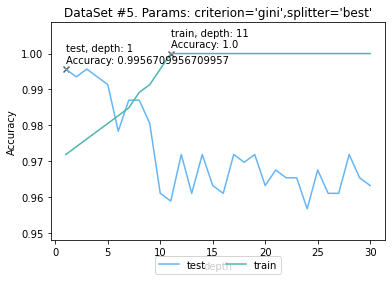

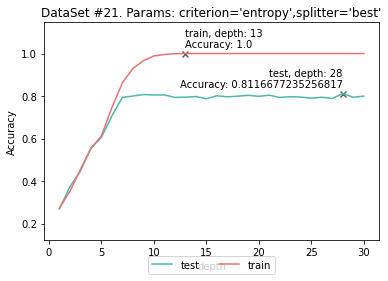

In [5]:
mds, mxds = dt(dss)

In [6]:
mds

(DataSet[n_features=10,size=924,split_size=1],
 {'criterion': 'gini', 'splitter': 'best'})

In [7]:
mxds

(DataSet[n_features=7,size=3154,split_size=1],
 {'criterion': 'entropy', 'splitter': 'best'})

{'criterion': 'gini', 'splitter': 'best'}
Fitting 1 folds for each of 396 candidates, totalling 396 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 396 out of 396 | elapsed:  2.5min finished


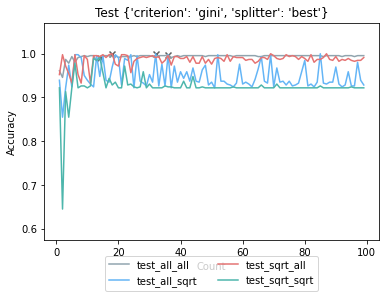

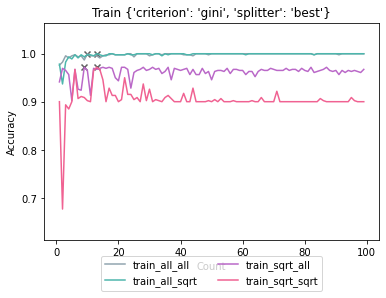

In [8]:
forest(mds[0], mds[1], verbose=True)

{'criterion': 'entropy', 'splitter': 'best'}
Fitting 1 folds for each of 396 candidates, totalling 396 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 396 out of 396 | elapsed:  8.4min finished


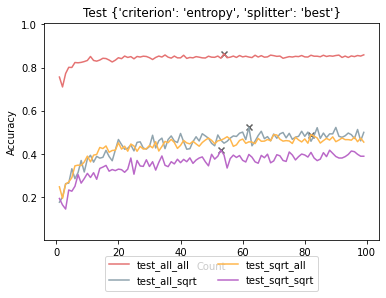

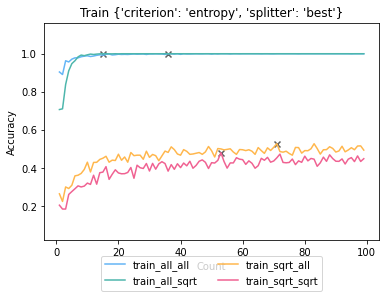

In [9]:
forest(mxds[0], mxds[1], verbose=True)